<a href="https://colab.research.google.com/github/junyi2022/musa-650-remote-sensing/blob/main/assignments/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MUSA 650 Homework 2: Supervised Land Use Classification with Google Earth Engine

In this assignment, you will use Google Earth Engine via Python to implement multi-class land cover classification. You will hand-label Landsat 8 satellite images which you will then use to train a random forest model. Along the way, you will consider practical remote sensing issues like cloud cover, class imbalances, and feature selection.

In particular, we encourage you to consult the [official Python Google Earth Engine `geemap` package](https://geemap.org/), the online course [Spatial Thoughts](https://spatialthoughts.com/courses/google-earth-engine/), and the [Google Earth Engine Tutorials book](https://google-earth-engine.com/).

Submit a single Jupyter Notebook containing code, narrative text, visualizations, and answers to each question. Please also upload your classification results as a GeoTIFF and your accuracy assessment as a CSV file. Open a pull request from your fork of this repository to the main repository for submission.

**Disclaimer:** I consulted the following AI tool to revise codes and answer questions for this project.

- DeepSeek. (n.d.). DeepSeek artificial intelligence system. Retrieved from https://www.deepseek.com

## 1. Setup

`geemap` has many [tutorials](https://geemap.org/tutorials/#geemap-tutorials) available. This notebook specificlly referenced the [#32 Machine Learning with Earth Engine - Supervised Classification](https://geemap.org/notebooks/32_supervised_classification/) and the video is available [here](https://www.youtube.com/watch?v=qWaEfgWi21o)

In [4]:
# Import required libraries
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display
import leafmap

import rasterio
import matplotlib
import numpy

import geopandas as gpd

Google Earth Engine requires authentication before usage. Instruction can be found [here](https://developers.google.com/earth-engine/guides/auth). The project is a google cloud project set up in the google cloud account. There is also a notebook autheticator [here](https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=jHMQOVzUM-B-pUwoeKSCPjAqmuPK90lbh-Z2xFjR55o&tc=n8BD6km8I2vhYIau8ww5Hrztwrd5Wulp0qdijy5YqII&cc=Yusop5Cp9Vxq3z_wUl9rzbY_q2YP5o1JUMM4lyLIvJs).

In [5]:
ee.Authenticate()
ee.Initialize(project='ee-musa-remote-sensing')

Create an interactive map. There are multriple base map available.  

**Note:** the output interactive map cannot be pushed to GitHub because the 'state' key is missing from 'metadata.widgets'. Remeber to clear output before pushing to GitHub.

In [ ]:
import os

os.environ["ROADMAP"] = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}'
os.environ["SATELLITE"] = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
os.environ["TERRAIN"] = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}'
os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

Map = geemap.Map()
Map.add_basemap("ROADMAP")
Map

## 2. Data Collection and Feature Engineering

### 2.1 Collecting and Labeling Training Data

Using the [interactive `geemap` intereface](https://www.youtube.com/watch?v=VWh5PxXPZw0) or another approach (e.g., QGIS, ArcGIS, a GeoJSON file, etc.), create at least 100 samples (points or polygons) for each of the following four classes: urban, bare, water, and vegetation. (Again, we encourage you to work in pairs or groups of three to generate these hand labels.) Use visual cues and manual inspection to ensure that the samples are accurate. Assign each class a unique label (e.g., 0 for urban, 1 for bare, 2 for water, and 3 for vegetation) and merge the labeled samples into a single dataset. You are free to propose any labels you like, as long as 1) you include at least 4 classes, and 2) you justify why they are appropriate for a remote sensing task (for example, including a label for ice cream shops wouldn't make sense, because those can't be detected from aerial imagery).

#### 2.1.1 Collecting Data

The region of interest (ROI) of this notebook is Chicago. We first start from adding data to the map. The data used is the Collection 2 for Landsat data in 2023. We filter for images with minimal cloud cover.  

The band info is showed in the form below:  
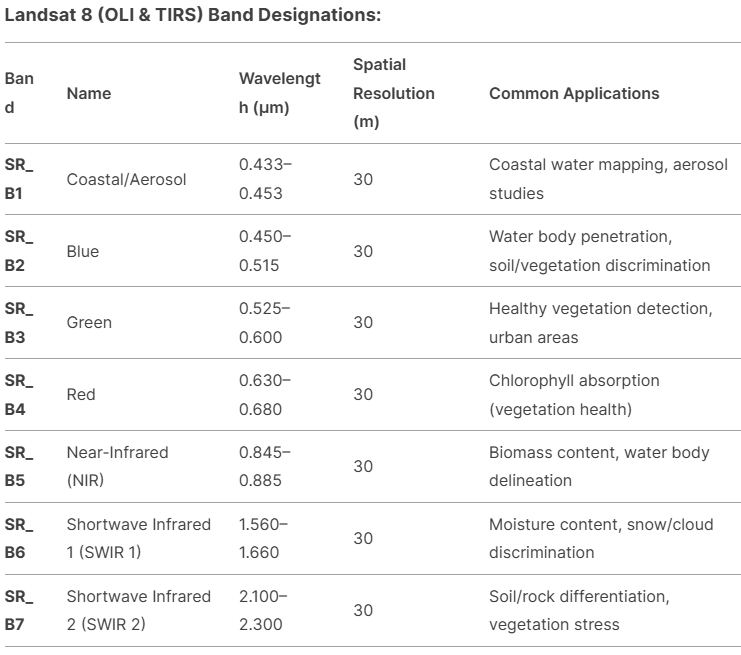

In [19]:
# Chicago point
point = ee.Geometry.Point([-87.7719, 41.8799])

image = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(point)
    .filterDate("2023-01-01", "2023-12-31")
    .sort("CLOUD_COVER")
    .first()
    .select("SR_B[1-7]")
)

vis_params = {"min": 0, "max": 3000, "bands": ["SR_B5", "SR_B4", "SR_B3"]}

Map.centerObject(point, 8)
Map.addLayer(image, vis_params, "Landsat-8")

Check image properties.

In [21]:
ee.Date(image.get("system:time_start")).format("YYYY-MM-dd").getInfo()

'2023-08-31'

In [22]:
image.get("CLOUD_COVER").getInfo()

0.16

#### 2.1.2 Labeling Data

### 2.2 Feature Engineering.

For possible use in the model, calculate and add the following spectral indices:

- **NDVI** (Normalized Difference Vegetation Index)
- **NDBI** (Normalized Difference Built-up Index)
- **MNDWI** (Modified Normalized Difference Water Index)

Additionally, add elevation and slope data from a DEM. Normalize all image bands to a 0 to 1 scale for consistent model input.

For bonus points, consider adding [kernel filters](https://google-earth-engine.com/Advanced-Image-Processing/Neighborhood-based-Image-Transformation/) (e.g., edge detection, smoothing) to see if they improve model performance.


## 3. Model Training and Evaluation

### 3.1 Model Training

Split your data into a training dataset (70%) and a validation dataset (30%). Train and evaluate a random forest model using the training set with all engineered features.

After training, analyze [variable importance scores](https://stackoverflow.com/questions/74519767/interpreting-variable-importance-from-random-forest-in-gee) to justify each feature's inclusion. Identify which features are most influential in the classification. Report the final features that you keep in your model.

### 3.2 Accuracy Assessment

Use the trained model to classify the Landsat 8 image, creating a land cover classification map with classes for urban, bare, water, and vegetation (or whatever classes you have chosen).

Using the validation data, generate a confusion matrix and calculate the overall accuracy, precision, and recall. Which classes were confused most often with each other? Why do you think this was?

Visually compare your landcover data for your ROI with the corresponding [landcover data from the European Space Agency](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200). Do your classifications agree? If not, do you notice any patterns in the types of landcover where they differ, or any particular features in the imagery that are hard for your model to recognize (e.g., sand, water, or asphalt)?

Export the classified image as a GeoTIFF and the confusion matrix and accuracy metrics to a CSV file for documentation.

## 4. Reflection Questions

What limitations did you run into when completing this assignment? What might you do differently if you repeated it, or what might you change if you had more time and/or resources?

What was the impact of feature engineering? Which layers most contributed to the model? Did you expect this? Why or why not?

Did you find it difficult to create the training data by hand? Did you notice any issues with class imbalance? If so, how might you resolve this in the future (hint: consider a different sampling technique).

Did your model perform better on one class than another? Why? Can you think of a reason that this might be good or bad depending on the context?
